## 1.准备阶段
训练数据集 `train_set` 以及测试数据集 `test_set`  
创建 `train_loader` 和 `test_loader` 用于训练以及测试过程的数据加载

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torchvision
import torchvision.transforms as transforms
import torch

# PyTorch device
print("CUDA Device Count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name:", torch.cuda.get_device_name(i))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"正在使用的是: {device}")

# 创建一个transform, 将 PIL 图片转换为 Tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# 自定义的帮助函数
from utils.helper_functions import * 

# 下载并加载 CIFAR-10 训练集
# root: 数据集存放路径 (如果路径不存在会自动创建)
# train=True: 指明要加载训练集
# download=True: 如果本地没有, 会自动从网络下载
# transform=transform: 对每张图片应用上面定义的 transform (即 ToTensor)
CIFAR10_trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 同理, 下载并加载 CIFAR-10 测试集
# train=False: 指明要加载测试集
CIFAR10_testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 调用 get_stats 计算训练集的通道均值和标准差
CIFAR_MEAN_TRAIN, CIFAR_STD_TRAIN = get_stats(CIFAR10_trainset)
print(f"CIFAR Train Set Mean: {CIFAR_MEAN_TRAIN[0]:.4f}, {CIFAR_MEAN_TRAIN[1]:.4f}, {CIFAR_MEAN_TRAIN[2]:.4f}")
print(f"CIFAR Train Set Std: {CIFAR_STD_TRAIN[0]:.4f}, {CIFAR_STD_TRAIN[1]:.4f}, {CIFAR_STD_TRAIN[2]:.4f}")

# 调用 get_stats 计算测试集的通道均值和标准差
CIFAR_MEAN_TEST, CIFAR_STD_TEST = get_stats(CIFAR10_testset)
print(f"CIFAR Test Set Mean: {CIFAR_MEAN_TEST[0]:.4f}, {CIFAR_MEAN_TEST[1]:.4f}, {CIFAR_MEAN_TEST[2]:.4f}")
print(f"CIFAR Test Set Std: {CIFAR_STD_TEST[0]:.4f}, {CIFAR_STD_TEST[1]:.4f}, {CIFAR_STD_TEST[2]:.4f}")

CUDA Device Count: 1
Device 0 Name: NVIDIA RTX A6000
正在使用的是: cuda
CIFAR Train Set Mean: 0.4914, 0.4822, 0.4465
CIFAR Train Set Std: 0.2470, 0.2435, 0.2616
CIFAR Test Set Mean: 0.4942, 0.4851, 0.4504
CIFAR Test Set Std: 0.2467, 0.2429, 0.2616


In [2]:
import numpy as np
import random
from torch.utils.data import ConcatDataset

# Set seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
     torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data transforms (normalization & data augmentation)
STATS_TRAIN = (CIFAR_MEAN_TRAIN, CIFAR_STD_TRAIN)
STATS_TEST = (CIFAR_MEAN_TEST, CIFAR_STD_TEST)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(*STATS_TRAIN),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*STATS_TEST)
])

# PyTorch datasets
train_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=test_transform
)

classes = train_set.classes
print(classes)

batch_size = 256
train_set_doubled = ConcatDataset([train_set, train_set])
train_loader = torch.utils.data.DataLoader(
    train_set_doubled, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True, # 异步复制
    num_workers=2
)
train_loader = DeviceDataLoader(train_loader, device)

test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=batch_size*2, 
    shuffle=False, 
    pin_memory=True, # 异步复制
    num_workers=2
)
test_loader = DeviceDataLoader(test_loader, device)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


显示一些训练图像:


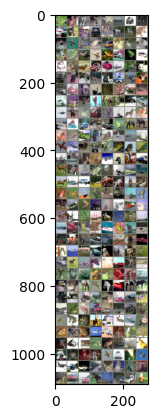

Labels: frog  cat   cat   deer  cat   ship  automobile bird  ship  dog   airplane automobile dog   deer  horse frog  frog  airplane deer  frog  automobile cat   dog   ship  dog   frog  automobile bird  frog  automobile frog  automobile cat   dog   deer  automobile automobile ship  frog  cat   automobile cat   cat   deer  dog   truck deer  deer  automobile automobile dog   bird  frog  bird  cat   deer  automobile ship  cat   bird  dog   cat   dog   automobile airplane deer  cat   truck deer  ship  dog   dog   ship  cat   automobile frog  automobile frog  horse horse dog   bird  truck cat   truck ship  airplane ship  airplane airplane dog   automobile cat   frog  dog   bird  ship  automobile bird  bird  airplane bird  horse truck horse truck ship  frog  dog   airplane ship  bird  horse ship  automobile horse automobile dog   ship  ship  bird  frog  bird  bird  deer  automobile airplane bird  horse ship  deer  ship  dog   airplane ship  ship  airplane airplane deer  ship  horse airplane b

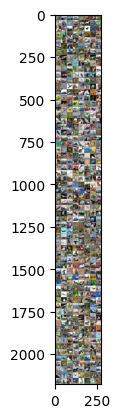

Labels: cat   ship  ship  airplane frog  frog  automobile frog  cat   automobile airplane truck dog   horse truck ship  dog   horse ship  frog  horse airplane deer  truck dog   bird  deer  airplane truck frog  frog  dog   deer  dog   truck bird  deer  automobile truck dog   deer  frog  dog   frog  airplane truck cat   truck horse frog  truck ship  airplane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  automobile bird  cat   horse bird  frog  ship  ship  airplane bird  truck cat   cat   ship  ship  automobile automobile horse bird  dog   bird  horse ship  truck airplane cat   ship  frog  deer  frog  frog  airplane airplane horse deer  dog   frog  cat   automobile automobile cat   frog  ship  horse deer  airplane frog  bird  automobile cat   airplane deer  bird  horse ship  cat   automobile bird  ship  airplane ship  cat   dog   bird  deer  automobile ship  truck automobile bird  truck horse bird  truck frog  dog   frog  cat   ship  horse frog  bird  dog  

In [3]:
import matplotlib.pyplot as plt

# Assuming train_loader and classes have been defined
print("显示一些训练图像:")
show_batch_images(
    train_loader, 
    classes, 
    batch_size, 
    CIFAR_MEAN_TRAIN, 
    CIFAR_STD_TRAIN
)

print("显示一些测试图像:")
show_batch_images(
    test_loader, 
    classes, 
    batch_size, 
    CIFAR_MEAN_TEST, 
    CIFAR_STD_TEST
)

## 2.创建分类器

In [4]:
model_0 = to_device(CNN_model(act_func="relu"), device)
# print(model_0)

# 输出模型的参数量、FLOPs、所占空间大小
model_info(model_0, device)

模型参数量为: 773842
FLOPs: 0.114 GFLOPs
Input size (MB): 0.01
Forward/backward pass size (MB): 12.84
Params size (MB): 2.95
Estimated Total Size (MB): 15.80


In [5]:
model_1 = to_device(CNN_model(act_func="tanh"), device)
# print(model_1)

# 输出模型的参数量、FLOPs、所占空间大小
model_info(model_1, device)

模型参数量为: 773842
FLOPs: 0.114 GFLOPs
Input size (MB): 0.01
Forward/backward pass size (MB): 12.84
Params size (MB): 2.95
Estimated Total Size (MB): 15.80


In [6]:
model_2 = to_device(CNN_model(act_func="sigmoid"), device)
# print(model_2)

# 输出模型的参数量、FLOPs、所占空间大小
model_info(model_2, device)

模型参数量为: 773842
FLOPs: 0.114 GFLOPs
Input size (MB): 0.01
Forward/backward pass size (MB): 12.84
Params size (MB): 2.95
Estimated Total Size (MB): 15.80


## 3.训练

In [7]:
# 设置超参数
epochs = 100
warmup_epochs = 5
max_lr = 0.001
grad_clip = 1
weight_decay = 1e-4
# 提前停止策略的参数
patience = 10
min_delta = 0.0001

In [8]:
# 最优模型的保存路径
best_model_path_0 = "./saved_weights/different_activation/best_model_0.pth"

# 检查目录是否存在, 如果不存在, 则创建
if not os.path.exists(os.path.dirname(best_model_path_0)):
    os.makedirs(os.path.dirname(best_model_path_0))

# 计算并输出初始模型(未训练前)的性能
history_0 = [evaluate(model_0, test_loader)]
print(history_0)

# 进行训练
history_0 += fit_with_warmup_adam(
    epochs, max_lr, model_0, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_0,
    patience=patience,
    min_delta=min_delta
)

[{'test_loss': 2.3029985427856445, 'test_acc': 0.10032743215560913}]
Epoch [1], learning_rate: 0.00020, train_loss: 2.1976, train_acc: 0.1533, test_loss: 1.8938, test_acc: 0.2611
New best model saved at epoch 1 with accuracy 0.2611
Epoch [2], learning_rate: 0.00040, train_loss: 1.8330, train_acc: 0.2976, test_loss: 1.6553, test_acc: 0.4060
New best model saved at epoch 2 with accuracy 0.4060
Epoch [3], learning_rate: 0.00060, train_loss: 1.5414, train_acc: 0.4399, test_loss: 1.3492, test_acc: 0.5037
New best model saved at epoch 3 with accuracy 0.5037
Epoch [4], learning_rate: 0.00080, train_loss: 1.2798, train_acc: 0.5496, test_loss: 1.1651, test_acc: 0.5794
New best model saved at epoch 4 with accuracy 0.5794
Epoch [5], learning_rate: 0.00100, train_loss: 1.1006, train_acc: 0.6167, test_loss: 1.0980, test_acc: 0.6222
New best model saved at epoch 5 with accuracy 0.6222
Epoch [6], learning_rate: 0.00100, train_loss: 0.9011, train_acc: 0.6880, test_loss: 0.8924, test_acc: 0.6910
New be

In [9]:
# 最优模型的保存路径
best_model_path_1 = "./saved_weights/different_activation/best_model_1.pth"

# 检查目录是否存在, 如果不存在, 则创建
if not os.path.exists(os.path.dirname(best_model_path_1)):
    os.makedirs(os.path.dirname(best_model_path_1))

# 计算并输出初始模型(未训练前)的性能
history_1 = [evaluate(model_1, test_loader)]
print(history_1)

# 进行训练
history_1 += fit_with_warmup_adam(
    epochs, max_lr, model_1, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_1,
    patience=patience,
    min_delta=min_delta
)

[{'test_loss': 2.3025848865509033, 'test_acc': 0.09989660233259201}]
Epoch [1], learning_rate: 0.00020, train_loss: 1.8902, train_acc: 0.3047, test_loss: 1.6007, test_acc: 0.4192
New best model saved at epoch 1 with accuracy 0.4192
Epoch [2], learning_rate: 0.00040, train_loss: 1.6256, train_acc: 0.4075, test_loss: 1.5243, test_acc: 0.4455
New best model saved at epoch 2 with accuracy 0.4455
Epoch [3], learning_rate: 0.00060, train_loss: 1.4582, train_acc: 0.4738, test_loss: 1.2822, test_acc: 0.5296
New best model saved at epoch 3 with accuracy 0.5296
Epoch [4], learning_rate: 0.00080, train_loss: 1.3235, train_acc: 0.5270, test_loss: 1.2004, test_acc: 0.5668
New best model saved at epoch 4 with accuracy 0.5668
Epoch [5], learning_rate: 0.00100, train_loss: 1.2106, train_acc: 0.5681, test_loss: 1.0704, test_acc: 0.6138
New best model saved at epoch 5 with accuracy 0.6138
Epoch [6], learning_rate: 0.00100, train_loss: 1.0453, train_acc: 0.6283, test_loss: 0.9808, test_acc: 0.6479
New be

In [10]:
# 最优模型的保存路径
best_model_path_2 = "./saved_weights/different_activation/best_model_2.pth"

# 检查目录是否存在, 如果不存在, 则创建
if not os.path.exists(os.path.dirname(best_model_path_2)):
    os.makedirs(os.path.dirname(best_model_path_2))

# 计算并输出初始模型(未训练前)的性能
history_2 = [evaluate(model_2, test_loader)]
print(history_2)

# 进行训练
history_2 += fit_with_warmup_adam(
    epochs, max_lr, model_2, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_2,
    patience=patience,
    min_delta=min_delta
)

[{'test_loss': 2.4212543964385986, 'test_acc': 0.09972426295280457}]
Epoch [1], learning_rate: 0.00020, train_loss: 2.1674, train_acc: 0.1823, test_loss: 1.9226, test_acc: 0.2225
New best model saved at epoch 1 with accuracy 0.2225
Epoch [2], learning_rate: 0.00040, train_loss: 1.7335, train_acc: 0.3133, test_loss: 3.0134, test_acc: 0.1182
Epoch [3], learning_rate: 0.00060, train_loss: 1.5055, train_acc: 0.4274, test_loss: 2.4502, test_acc: 0.2077
Epoch [4], learning_rate: 0.00080, train_loss: 1.3709, train_acc: 0.4935, test_loss: 2.8360, test_acc: 0.1799
Epoch [5], learning_rate: 0.00100, train_loss: 1.3055, train_acc: 0.5221, test_loss: 3.9181, test_acc: 0.1399
Epoch [6], learning_rate: 0.00100, train_loss: 1.1860, train_acc: 0.5720, test_loss: 2.8513, test_acc: 0.2562
New best model saved at epoch 6 with accuracy 0.2562
Epoch [7], learning_rate: 0.00100, train_loss: 1.1467, train_acc: 0.5879, test_loss: 3.1401, test_acc: 0.2155
Epoch [8], learning_rate: 0.00100, train_loss: 1.1170, 

## 4.模型性能

### (1) 基础学习率变化

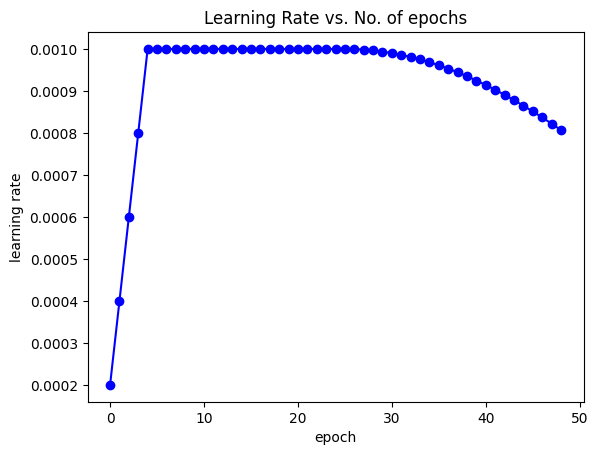

In [26]:
# 绘制模型基础学习率变化
lr = np.concatenate([x.get('lrs', []) for x in history_0])
plt.plot(lr, '-bo')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.title('Learning Rate vs. No. of epochs')
# plt.savefig('./figures/learning_rate.pdf')
plt.show()

### (2) 准确率

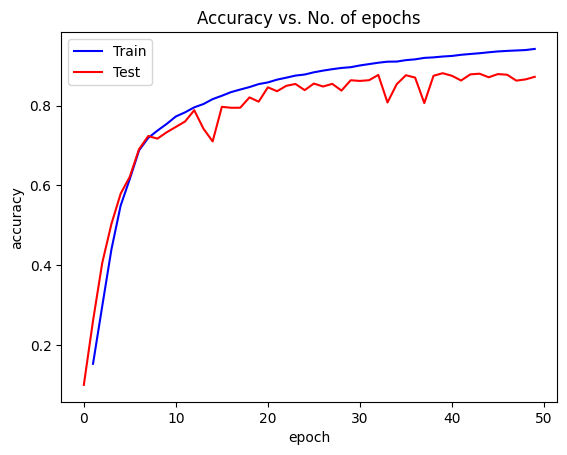

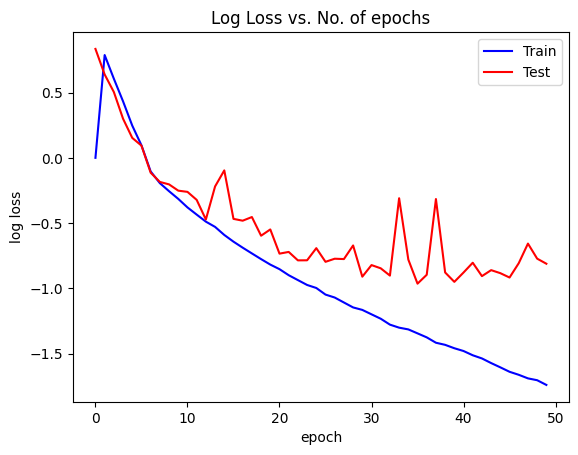

In [34]:
# 绘制 history_0
plot_accuracies(history_0)
plot_log_loss(history_0)

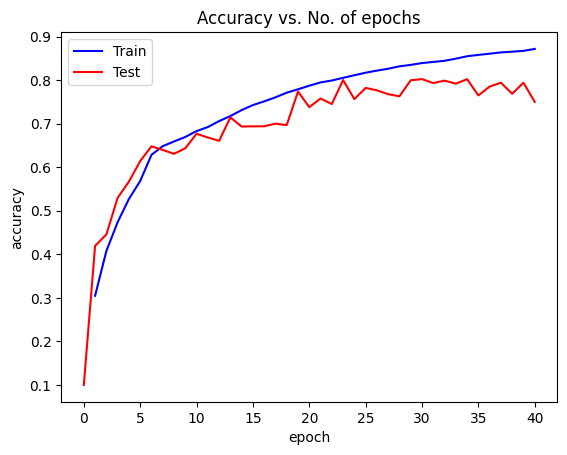

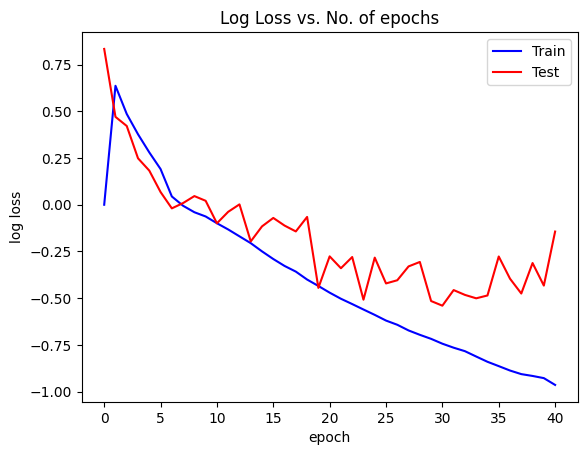

In [35]:
# 绘制 history_1
plot_accuracies(history_1)
plot_log_loss(history_1)

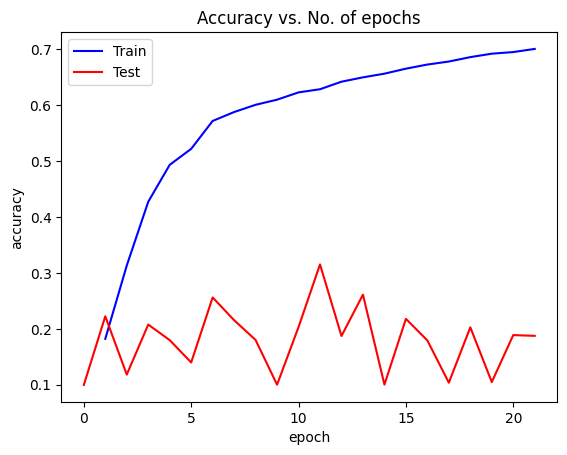

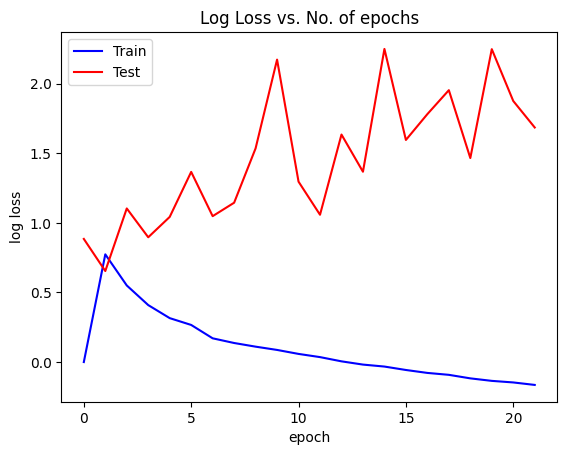

In [36]:
# 绘制 history_2
plot_accuracies(history_2)
plot_log_loss(history_2)

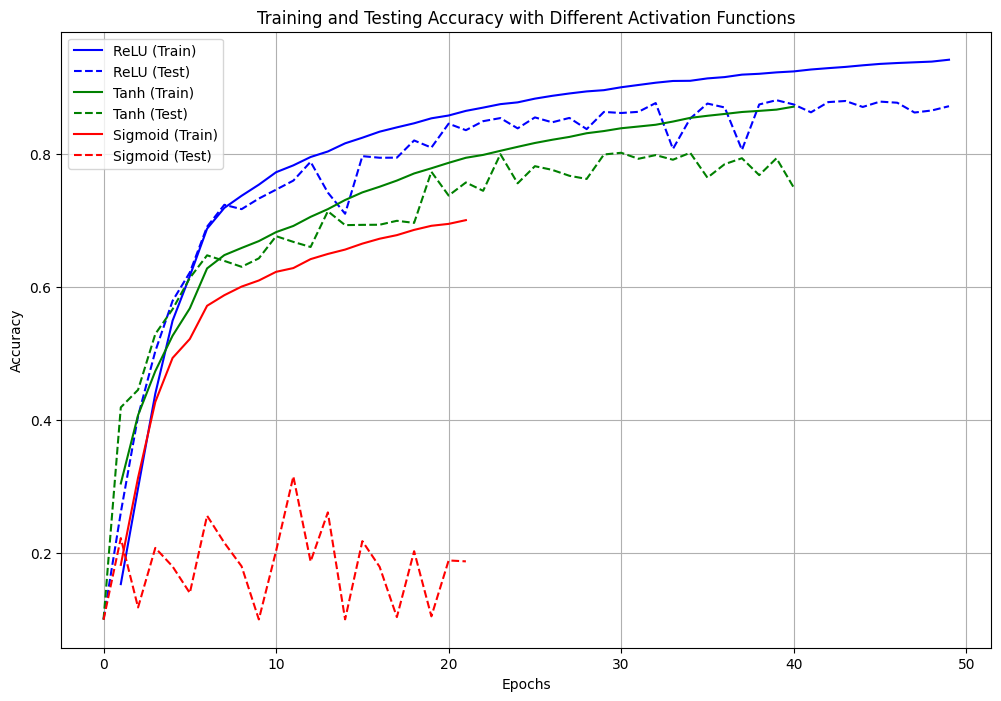

In [15]:
# Accuracy comparison of different models on CIFAR-10
# Data for model 0
test_acc_0 = [x['test_acc'] for x in history_0]
train_acc_0 = [x.get('train_acc') for x in history_0]

# Data for model 1
test_acc_1 = [x['test_acc'] for x in history_1]
train_acc_1 = [x.get('train_acc') for x in history_1]

# Data for model 2
test_acc_2 = [x['test_acc'] for x in history_2]
train_acc_2 = [x.get('train_acc') for x in history_2]

# Plotting
plt.figure(figsize=(12, 8))

# Model 0
plt.plot(train_acc_0, label='ReLU (Train)', color='blue', linestyle='-')
plt.plot(test_acc_0, label='ReLU (Test)', color='blue', linestyle='--')

# Model 1
plt.plot(train_acc_1, label='Tanh (Train)', color='green', linestyle='-')
plt.plot(test_acc_1, label='Tanh (Test)', color='green', linestyle='--')

# Model 2
plt.plot(train_acc_2, label='Sigmoid (Train)', color='red', linestyle='-')
plt.plot(test_acc_2, label='Sigmoid (Test)', color='red', linestyle='--')

plt.title('Training and Testing Accuracy with Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('./figures/accuracy_different_activation.pdf', dpi=300)
plt.show()

### (3) 加载最优模型 & 计算精确率

In [16]:
# 恢复模型状态
checkpoint = torch.load(best_model_path_0)
model_0.load_state_dict(checkpoint['model_state_dict'])

# 计算精确率
average_precision(model_0, test_loader, classes)

Precision of class airplane: 	0.8416
Precision of class automobile: 	0.9015
Precision of class bird: 	0.9269
Precision of class cat: 	0.7614
Precision of class deer: 	0.8883
Precision of class dog: 	0.8417
Precision of class frog: 	0.8811
Precision of class horse: 	0.9270
Precision of class ship: 	0.9307
Precision of class truck: 	0.9204
The Average precision value is 0.8821



In [17]:
# 最优模型的保存路径
epochs = 1
best_model_path_0 = "./saved_weights/different_activation/best_model_0_next.pth"

# 检查目录是否存在, 如果不存在, 则创建
if not os.path.exists(os.path.dirname(best_model_path_0)):
    os.makedirs(os.path.dirname(best_model_path_0))

# 计算并输出初始模型(未训练前)的性能
history_0_next = [evaluate(model_0, test_loader)]
print(history_0_next)

# 进行训练
history_0_next += fit_with_warmup_adam(
    epochs, max_lr, model_0, train_loader, test_loader,
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    warmup_epochs=warmup_epochs,
    best_model_path=best_model_path_0,
    patience=patience,
    min_delta=min_delta
)

[{'test_loss': 0.38677042722702026, 'test_acc': 0.8813304305076599}]
Epoch [1], learning_rate: 0.00020, train_loss: 0.1484, train_acc: 0.9511, test_loss: 0.3358, test_acc: 0.9031
New best model saved at epoch 1 with accuracy 0.9031


In [18]:
# 恢复模型状态
checkpoint = torch.load(best_model_path_1)
model_1.load_state_dict(checkpoint['model_state_dict'])

# 计算精确率
average_precision(model_1, test_loader, classes)

Precision of class airplane: 	0.8219
Precision of class automobile: 	0.8923
Precision of class bird: 	0.8814
Precision of class cat: 	0.7944
Precision of class deer: 	0.8263
Precision of class dog: 	0.6346
Precision of class frog: 	0.6833
Precision of class horse: 	0.9234
Precision of class ship: 	0.8338
Precision of class truck: 	0.8674
The Average precision value is 0.8159



In [32]:
# 恢复模型状态
checkpoint = torch.load(best_model_path_2)
model_2.load_state_dict(checkpoint['model_state_dict'])

# 计算精确率
average_precision(model_2, test_loader, classes)

Precision of class airplane: 	0.3198
Precision of class automobile: 	0.9564
Precision of class bird: 	N/A (no predicted positives)
Precision of class cat: 	0.5625
Precision of class deer: 	N/A (no predicted positives)
Precision of class dog: 	0.5532
Precision of class frog: 	N/A (no predicted positives)
Precision of class horse: 	0.2794
Precision of class ship: 	0.3250
Precision of class truck: 	0.2462
The Average precision value is 0.4632



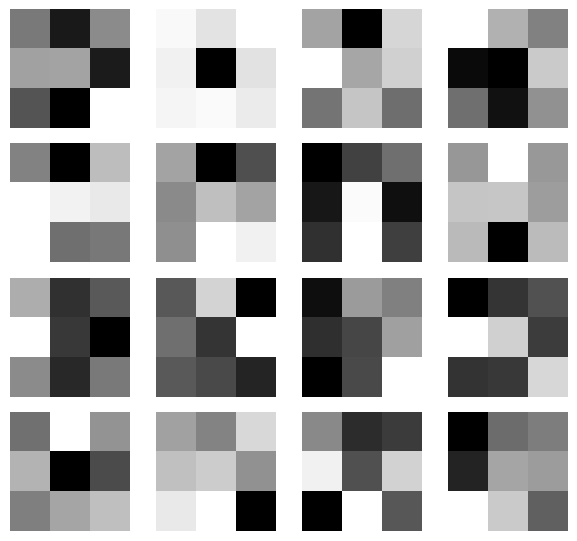

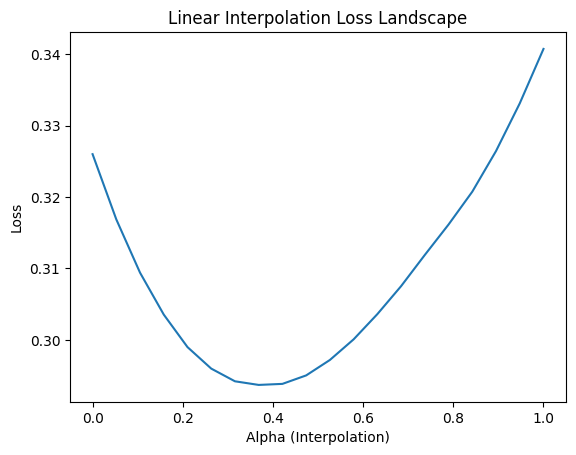

In [ ]:
# 1. Filter visualization (first layer of stem)
visualize_filters(model_0, layer_name='stem.0', num_filters=16, save_path='./figures/filter_visualization.pdf')

# 2. Loss landscape interpolation
# Save two states: e.g., initial random weights vs. trained model
checkpoint = torch.load('./saved_weights/different_activation/best_model_0.pth')
initial_state = {k: v.clone().cpu() for k, v in checkpoint['model_state_dict'].items()}
checkpoint = torch.load('./saved_weights/different_activation/best_model_0_next.pth')
trained_state = {k: v.clone().cpu() for k, v in checkpoint['model_state_dict'].items()}
criterion = nn.CrossEntropyLoss()
interpolate_loss(model_0, criterion, test_loader, initial_state, trained_state, steps=20)

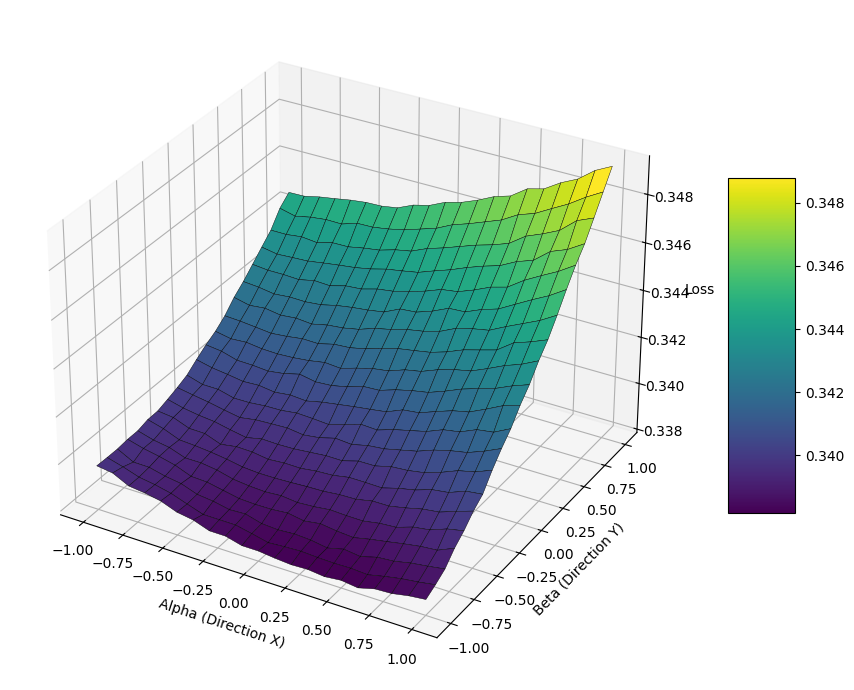

In [24]:
# Model and loss
model = model_0.to(device)
criterion = nn.CrossEntropyLoss()

# Load checkpoint into model (e.g., best_model_0_next.pth)
checkpoint = torch.load('./saved_weights/different_activation/best_model_0_next.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 3D loss landscape
plot_loss_landscape_3D(model, criterion, test_loader, steps=21, scale=1.0)